In [1]:
%matplotlib inline

import setGPU

import os, h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize

import glob

setGPU: Setting GPU to: 1


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plotHistogram(real_sum, generated_sum, epoch='', bins=7):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    na, bina, _ = ax.hist(real_sum, alpha=0.3, bins=bins, label='real sum', color='blue')
    nb, binb, _ = ax.hist(generated_sum, alpha=0.3, bins=bins, label='generated sum', color='red')
    plt.legend(prop={'size': 15})
    plt.title("Sum of energies - epoch " + str(epoch), size=16)
    ax.set_xlabel('Energy (GeV)', size=16)
    ax.set_ylabel('n events', size=16)
    #plt.show()
    #plt.savefig('images/pred_%s.png'%epoch)
    return [(na, bina), (nb, binb)]

In [12]:
gen_model1 = '/nfshome/vitoriabp/hgcal_wgan/trial23/weights/generator_model_bs_128_lr_0.00005_latent_100_ncritic_5_clip_0.01_shuffle.json'
g_weight1 = '/nfshome/vitoriabp/hgcal_wgan/trial23/weights/generator_weights_epoch_2925_bs_128_lr_0.00005_latent_100_ncritic_5_clip_0.01_shuffle.h5'

g = loadModel(gen_model1)
g.load_weights(g_weight1)
generated_images = g.predict(noise)

In [48]:
generated_images.shape

(200, 16, 16, 55)

In [49]:
from scipy.stats import moment

In [76]:
m1 = moment(generated_images, moment=1, axis=None)

In [85]:
"%.9f" % m1

'0.000000000'

In [74]:
np.where(moment(generated_images, moment=2, axis=1) != 0)

(array([  0,   0,   0, ..., 199, 199, 199]),
 array([ 0,  0,  0, ..., 15, 15, 15]),
 array([ 0,  4,  8, ..., 44, 48, 51]))

In [52]:
np.mean(generated_images)

0.023811387

In [77]:
m2 = moment(generated_images, moment=2, axis=None)

In [82]:
m2

0.06796336

In [79]:
var = m2 - m1**2

In [87]:
var

0.0679633617401123

In [88]:
np.var(generated_images)

0.06796336

In [83]:
std = np.sqrt(var)

In [84]:
std

0.2606978360863632

In [64]:
np.std(generated_images)

0.26069784

In [65]:
moment(generated_images, moment=3, axis=None)

0.4484018

In [86]:
moment(generated_images, moment=4, axis=None)

4.1928406

In [59]:
np.mean(generated_images, axis=(0, 1, 2, 3))

0.023811387

In [14]:
gen_sum = np.sum(generated_images, axis=(1, 2, 3))

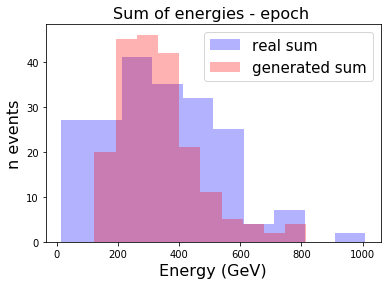

In [23]:
x = plotHistogram(inp_sum, gen_sum, bins=10)

In [21]:
na = x[0][0]
bina = x[0][1]

array([27., 27., 41., 35., 32., 25.,  4.,  7.,  0.,  2.])

In [26]:
nb = x[1][0]
binb = x[1][1]

In [110]:
energies = np.linspace(start=min(min(bina), min(binb)), stop=max(max(bina), max(binb)), num=10)

In [45]:
ratios = np.log(np.max([nb, np.ones(len(nb))*1E-4], axis=0) / np.max([na, np.ones(len(na))*1E-4], axis=0))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


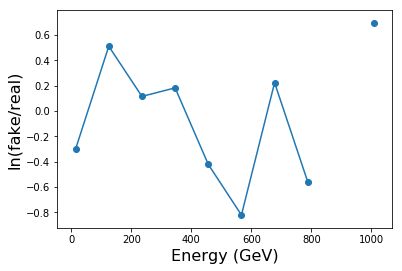

In [120]:
plt.plot(energies, ratios)
plt.scatter(energies, ratios)
plt.xlabel("Energy (GeV)", size=16)
plt.ylabel("ln(fake/real)", size=16)

In [3]:
def loadModel(name, weights=False):
    '''
    Adapted from Kaustuv Datta and Jayesh Mahapatra's CaloImageMacros.
    Loads models from json file.
    :parameter name: name of the json file.
    :type name: str
    :parameter weights: whether or not to load the weights.
    :type weights: bool
    :return: loaded model.
    '''
    from keras.models import model_from_json
    json_file = open('%s' % name, 'r')
    loaded = json_file.read()
    json_file.close()

    model = model_from_json(loaded)

    # load weights into new model
    if weights == True:
        model.load_weights('%s.h5' % name)
    # print(model.summary())

    #print("Loaded model from disk")
    return model

In [4]:
n_samples = 200

f = h5py.File('/bigdata/shared/HGCAL_data/new/all_noPU.h5', 'r')
X = np.asarray(f['X'])
X = X.squeeze()
inp_sum = np.sum(X[0:n_samples], axis = (1, 2, 3))

latent_space=100
noise = np.random.normal(0, 1, (n_samples, latent_space))

In [5]:
all_g_weight1 = '/nfshome/vitoriabp/hgcal_wgan/trial23/weights/generator_weights_epoch_*.h5'
gen_model1 = '/nfshome/vitoriabp/hgcal_wgan/trial23/weights/generator_model_bs_128_lr_0.00005_latent_100_ncritic_5_clip_0.01_shuffle.json'

In [6]:
all_g_weight2 = '/nfshome/vitoriabp/hgcal_wgan/trial26/weights/generator_weights_epoch_*.h5'
gen_model2 = '/nfshome/vitoriabp/hgcal_wgan/trial26/weights/generator_model_change_discriminator.json'

In [7]:
def plotHist(inp_sum, all_g_weight, gen_model):
    g = loadModel(gen_model)

    for w in glob.glob(all_g_weight):
        epoch = w.split('/')[-1].split('_')[3]
        g.load_weights(w)
        generated_images = g.predict(noise)
        generated_images = generated_images.squeeze()
        gen_sum = np.sum(generated_images, axis=(1, 2, 3))
        plotHistogram(inp_sum, gen_sum, epoch, bins = 10)

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


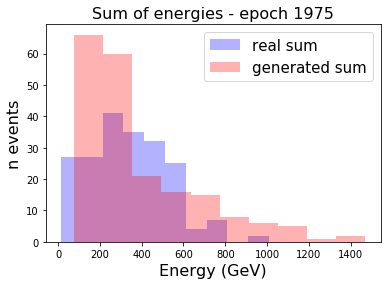

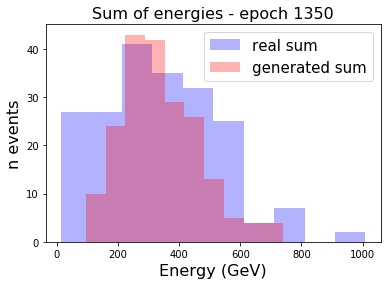

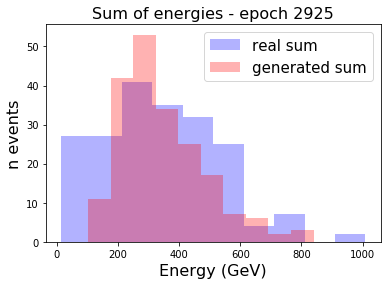

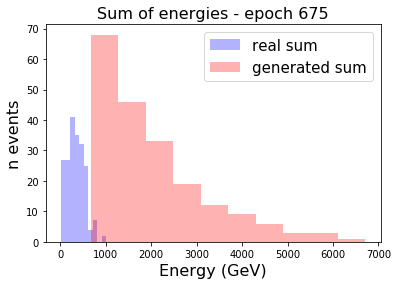

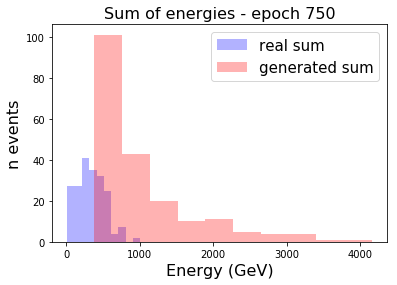

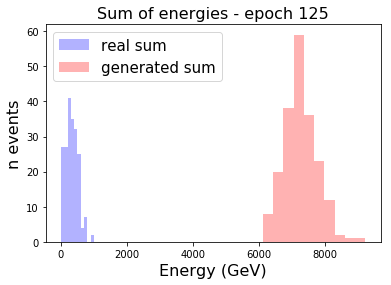

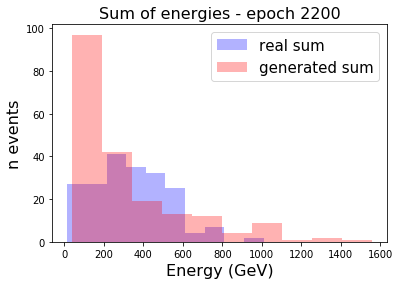

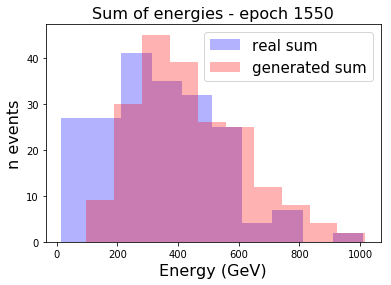

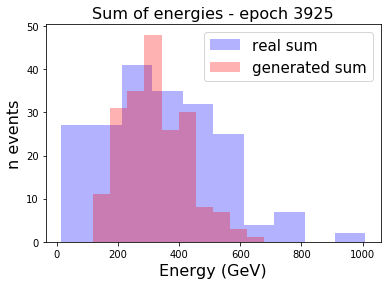

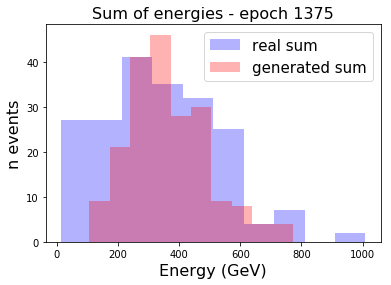

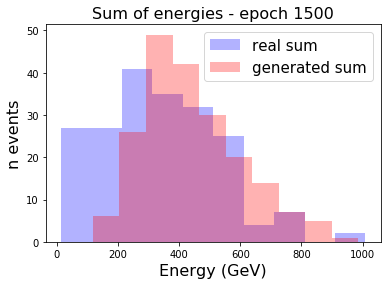

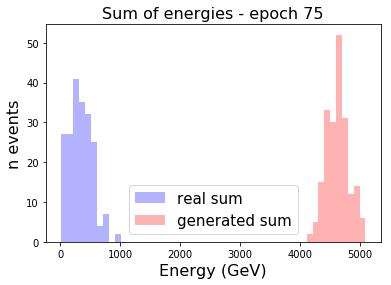

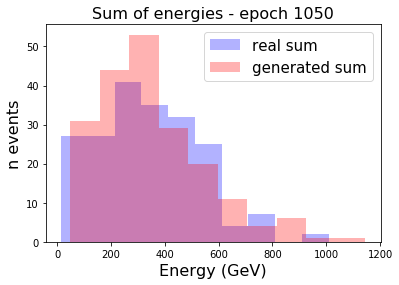

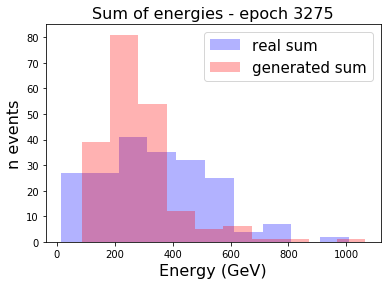

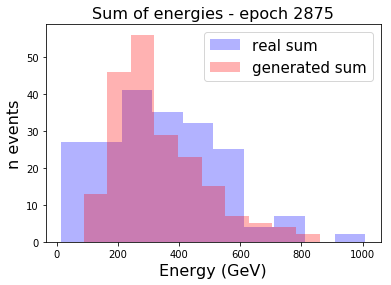

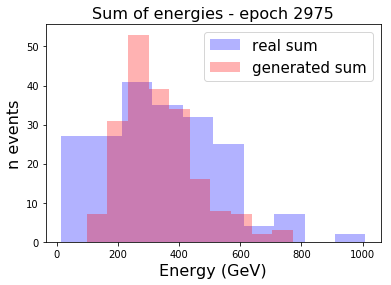

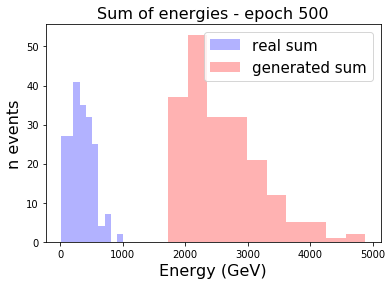

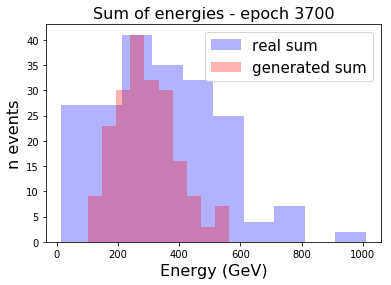

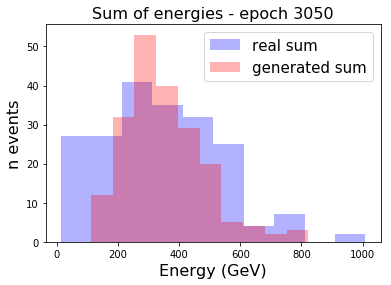

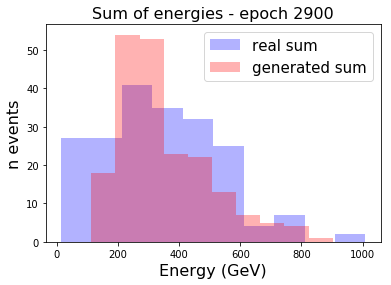

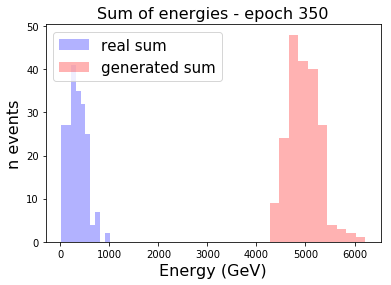

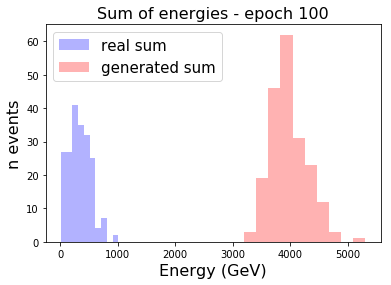

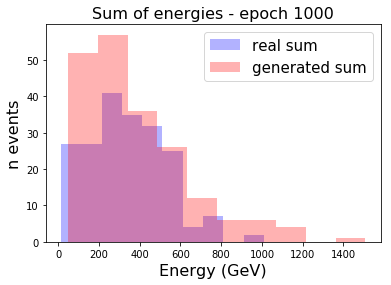

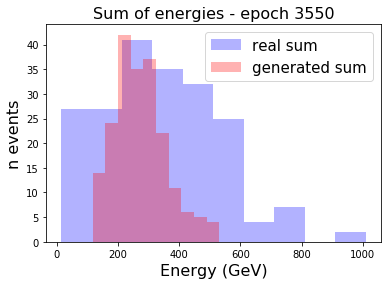

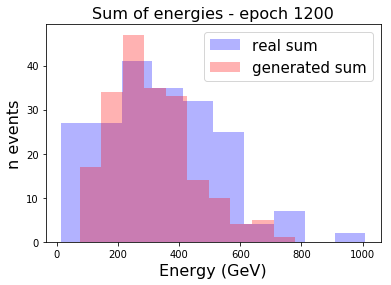

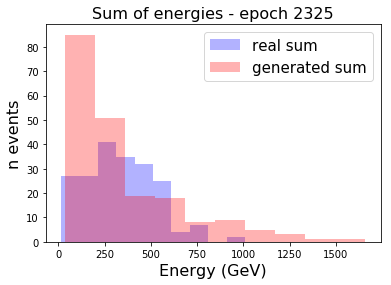

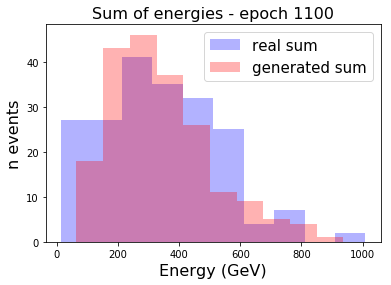

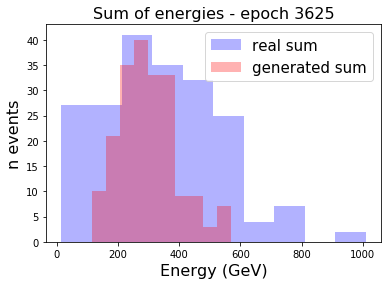

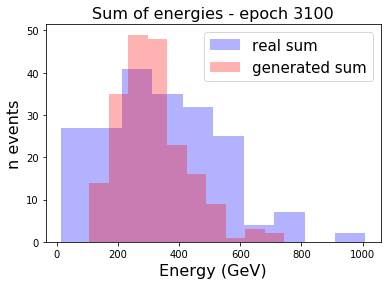

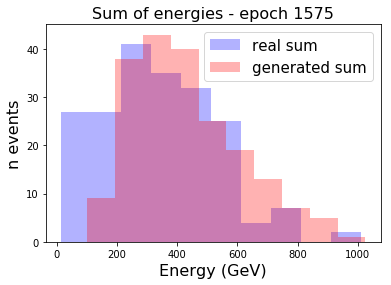

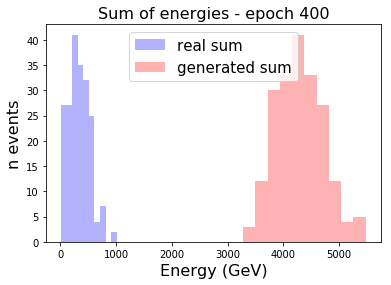

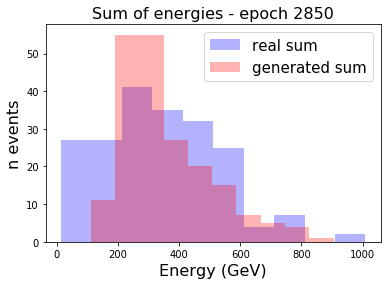

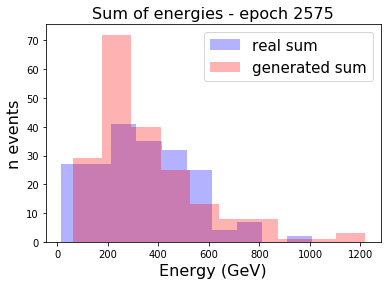

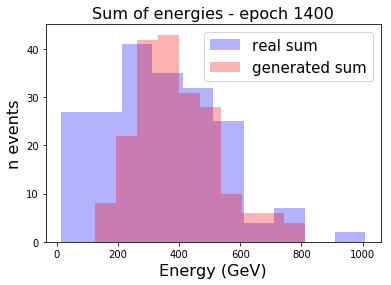

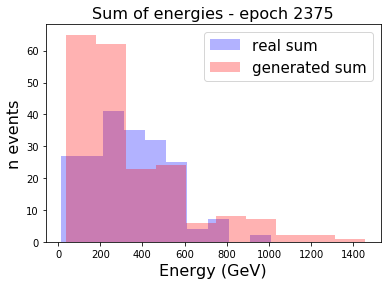

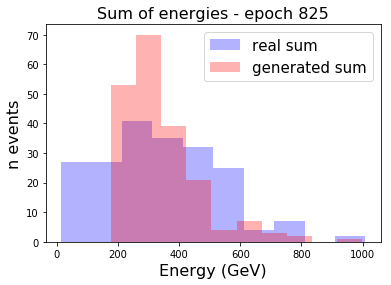

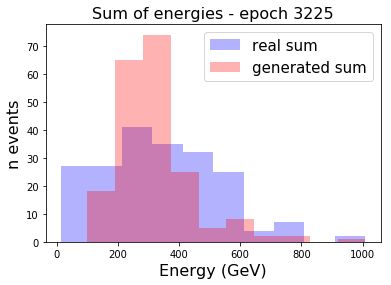

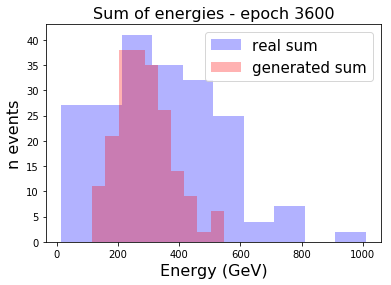

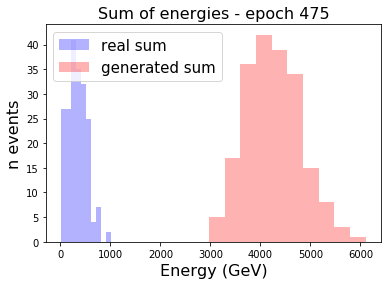

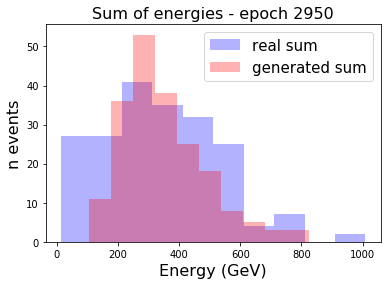

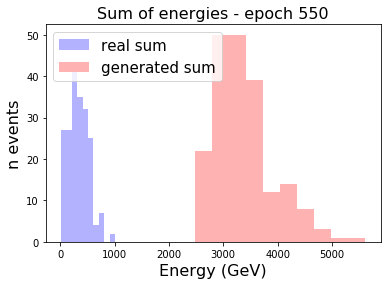

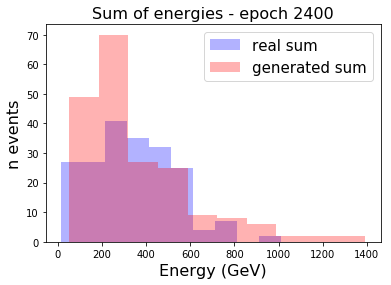

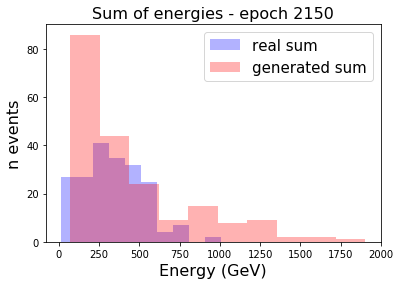

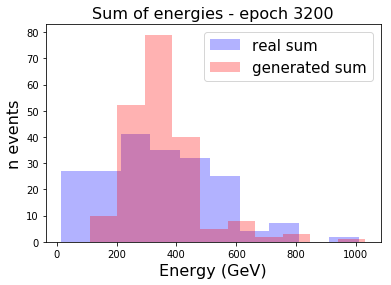

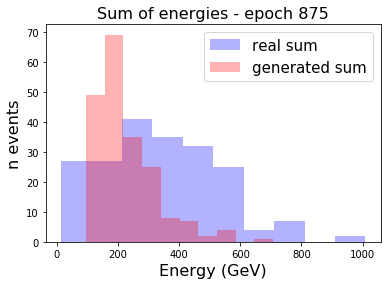

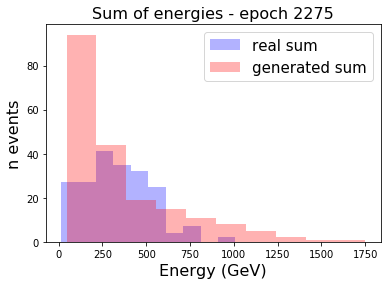

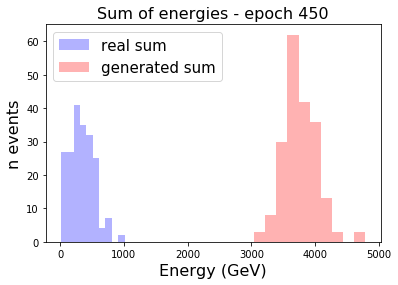

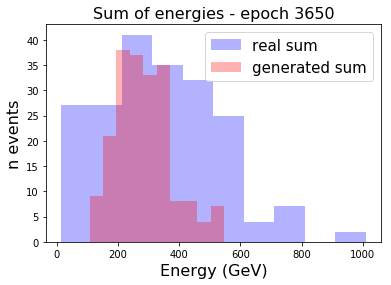

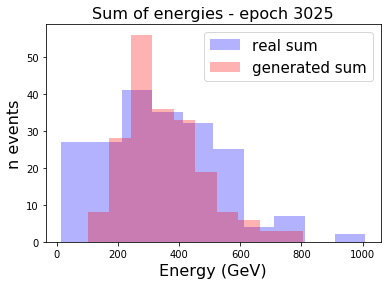

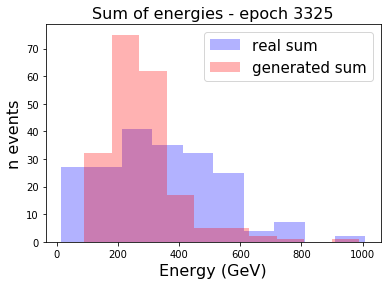

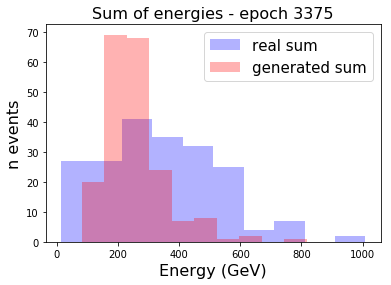

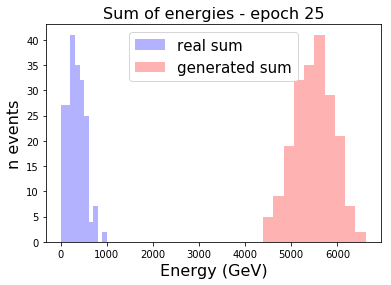

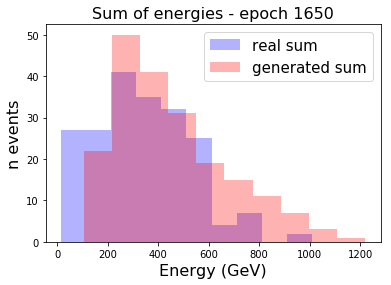

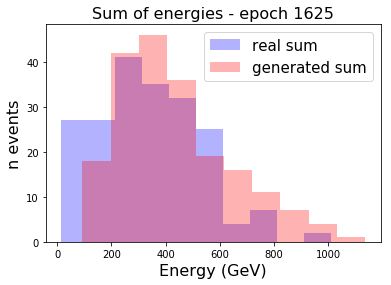

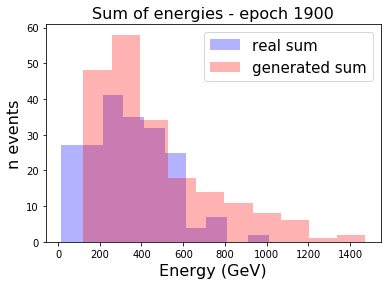

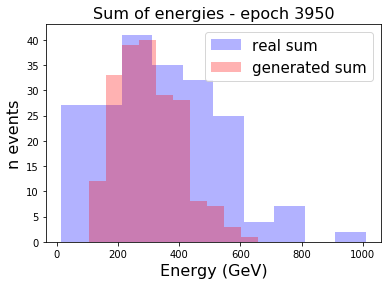

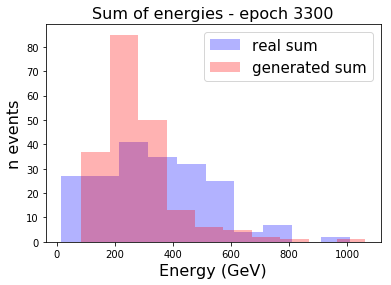

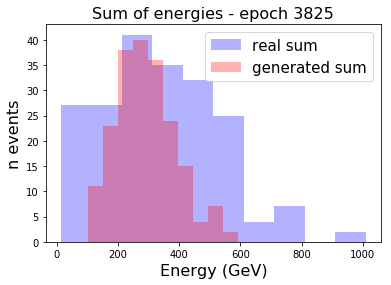

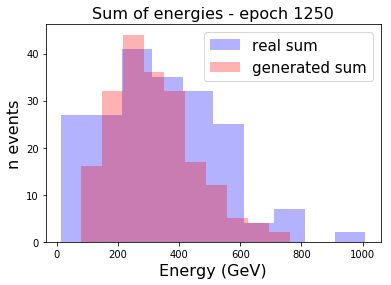

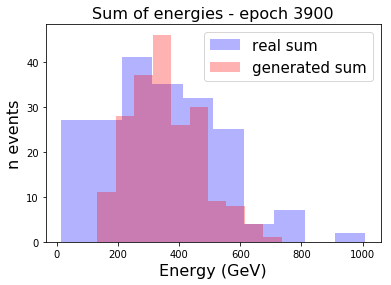

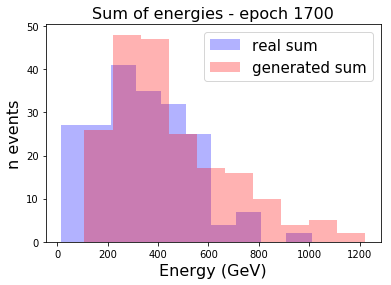

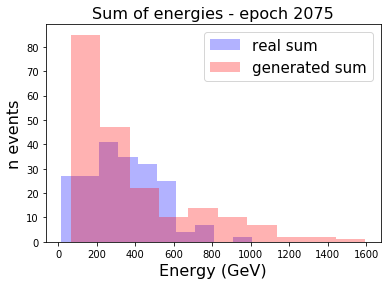

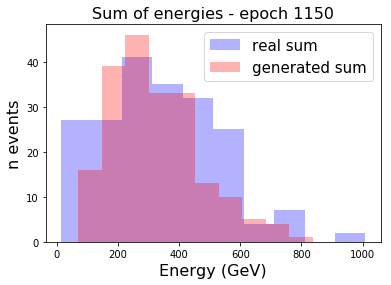

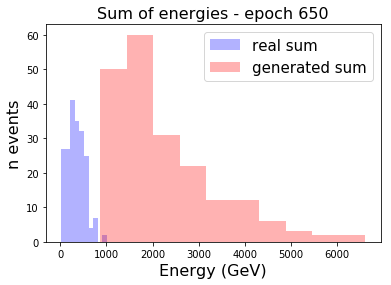

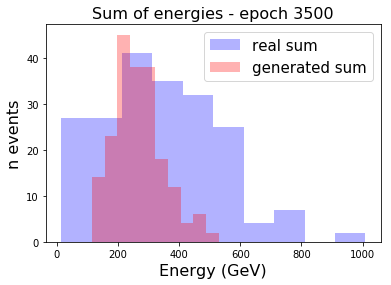

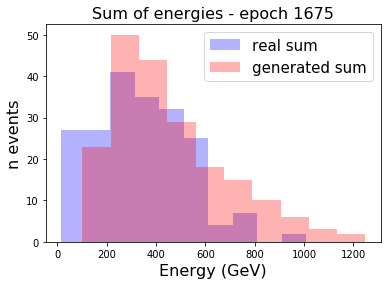

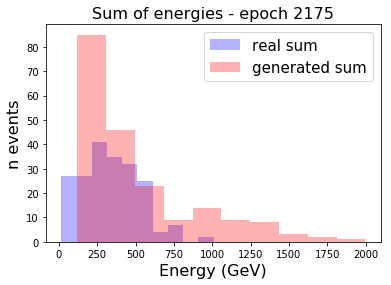

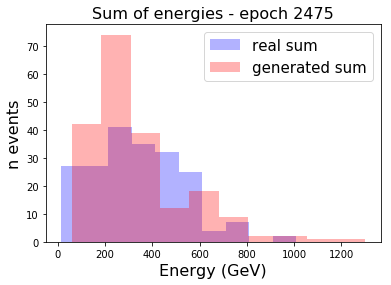

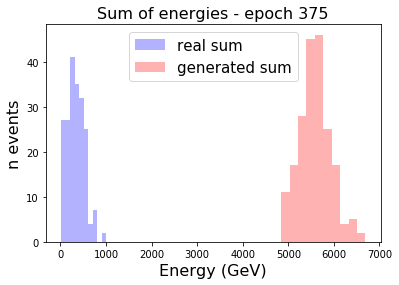

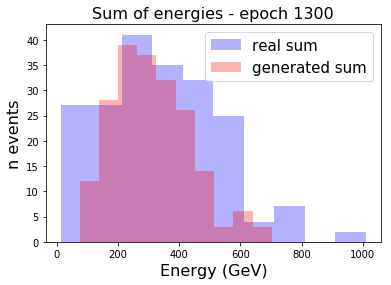

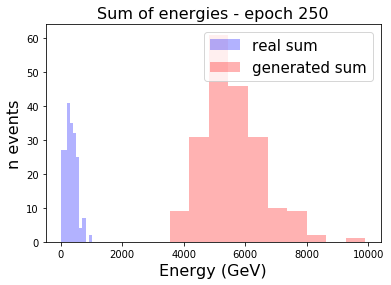

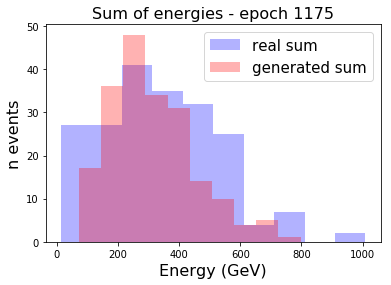

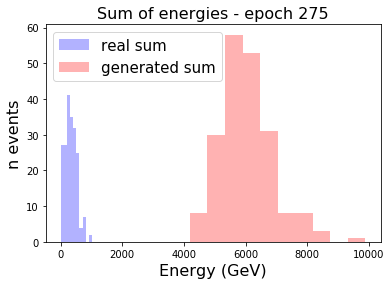

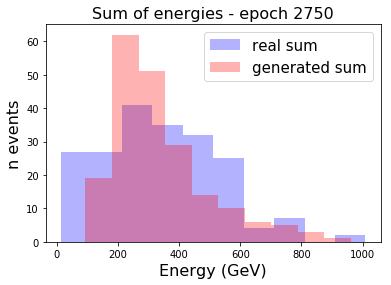

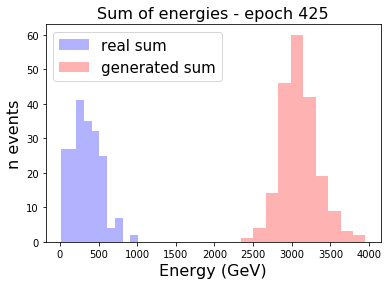

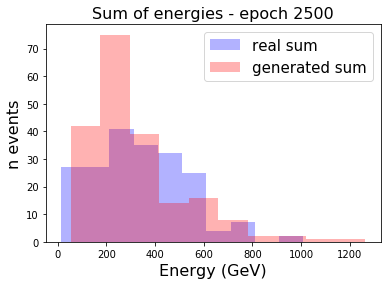

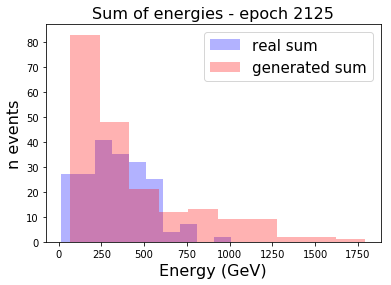

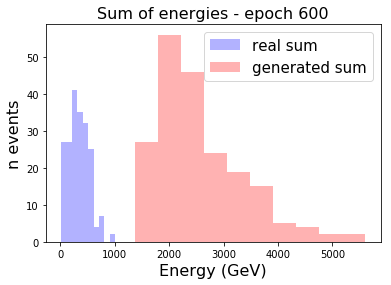

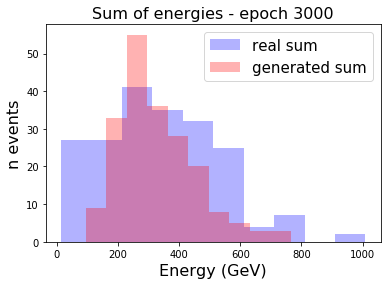

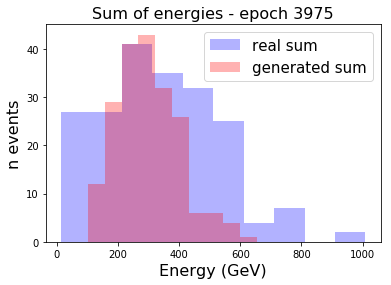

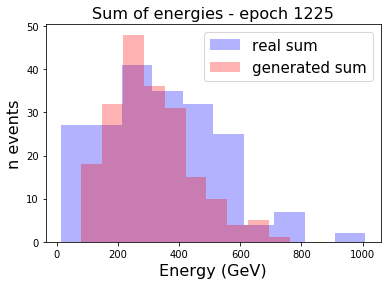

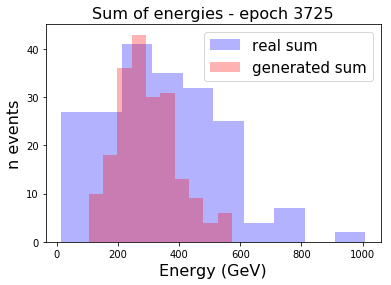

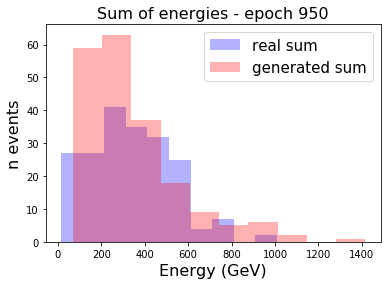

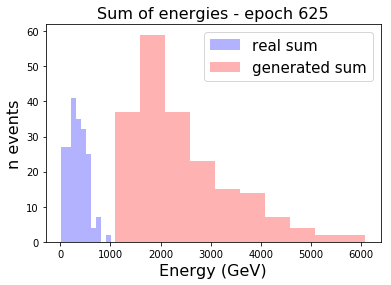

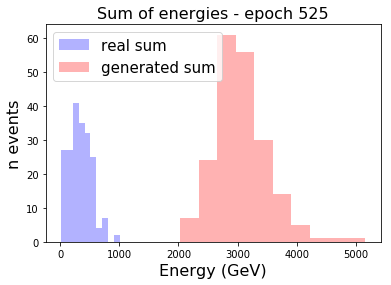

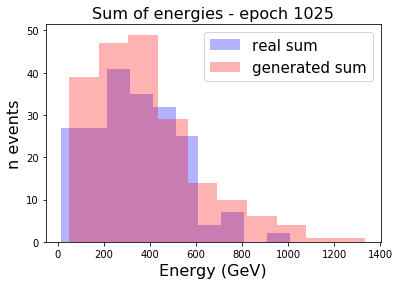

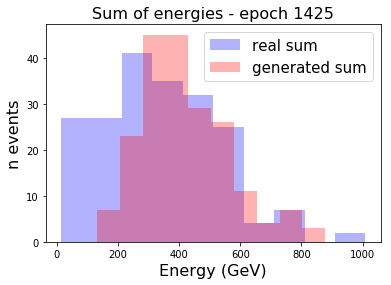

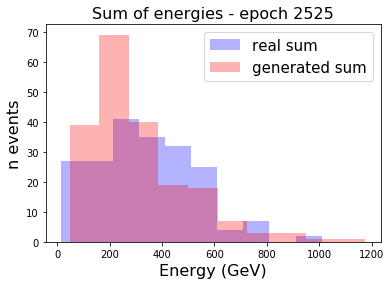

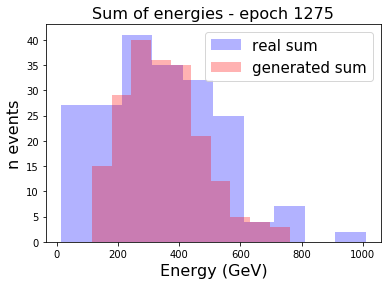

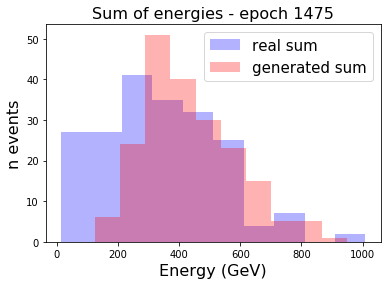

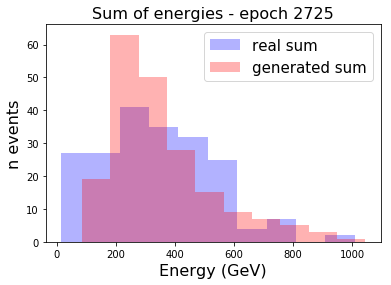

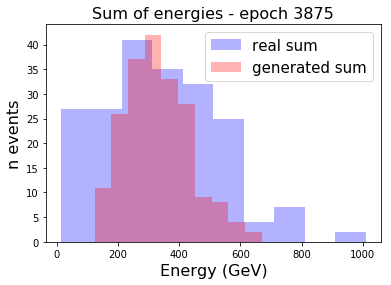

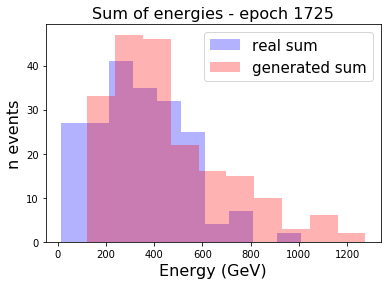

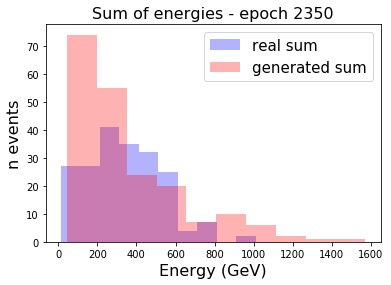

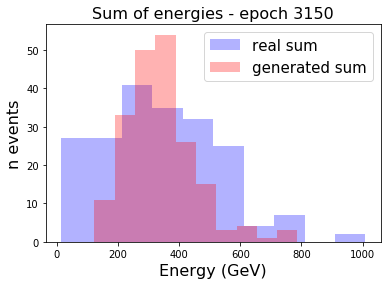

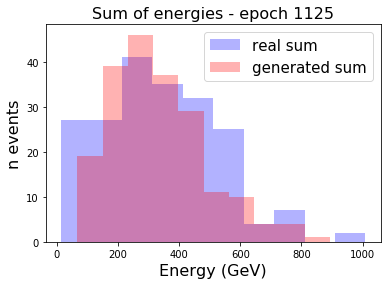

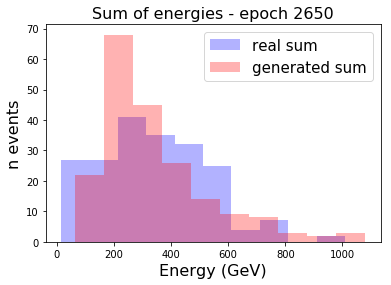

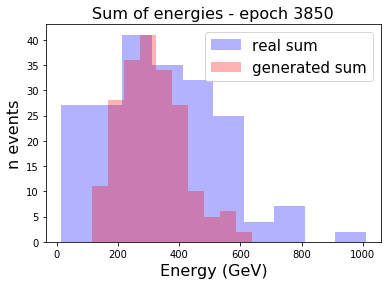

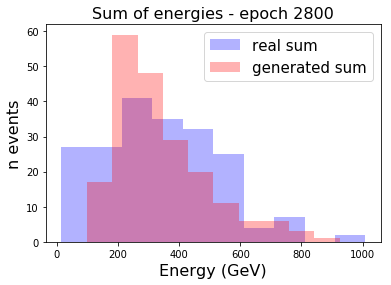

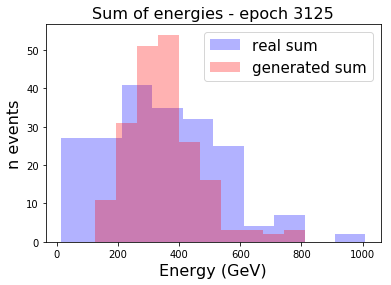

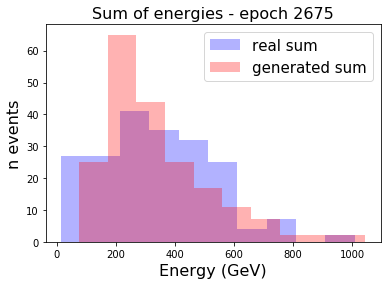

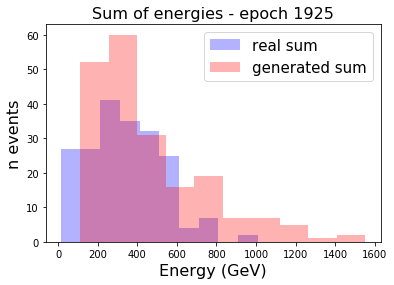

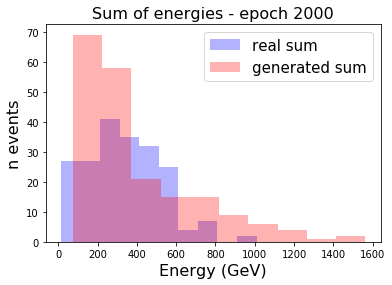

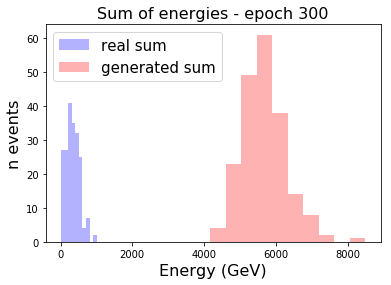

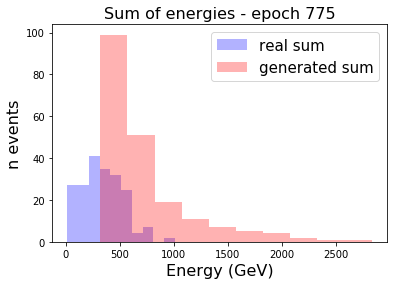

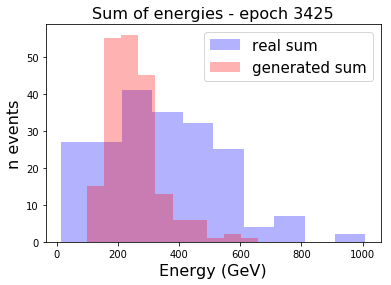

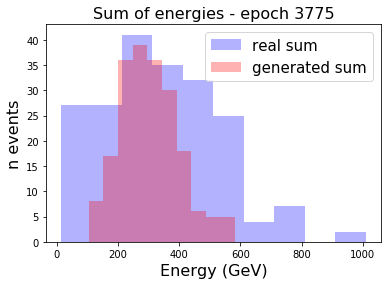

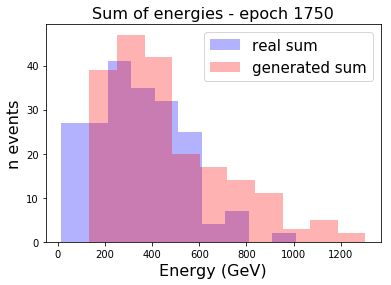

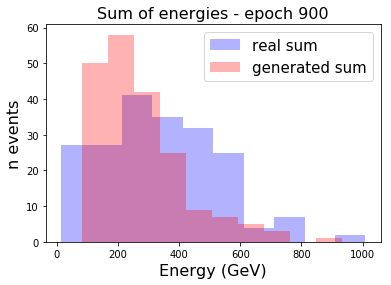

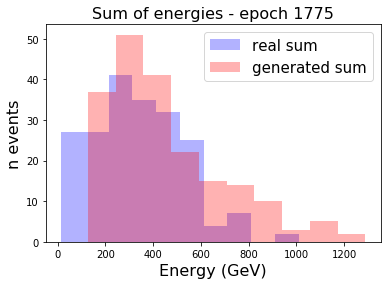

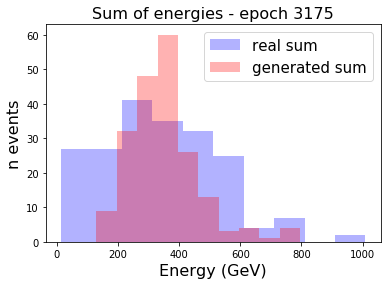

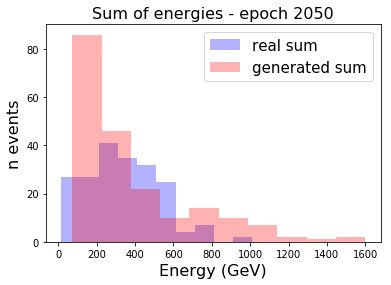

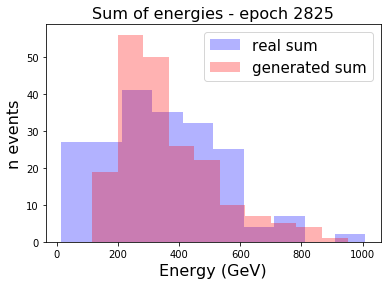

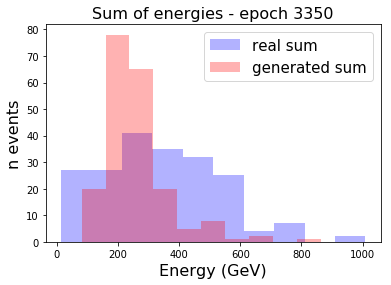

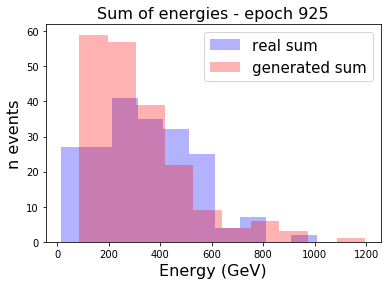

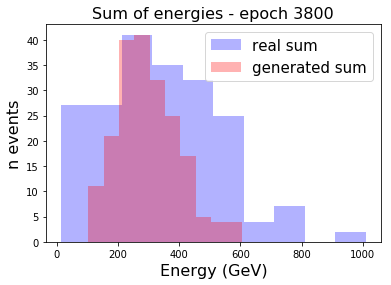

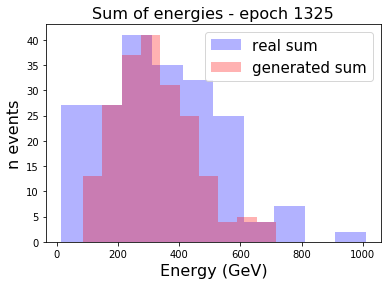

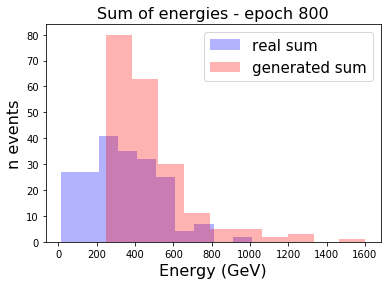

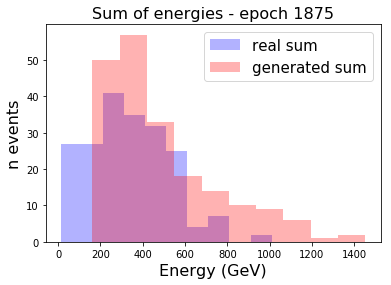

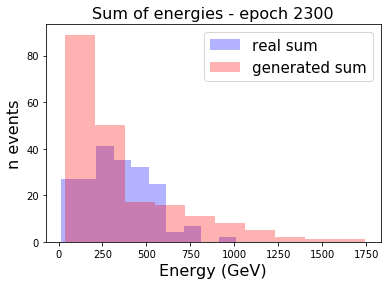

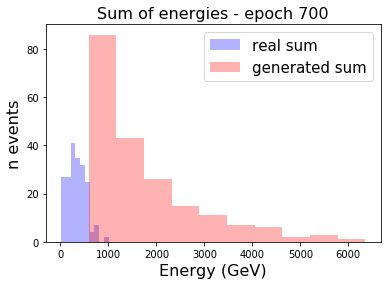

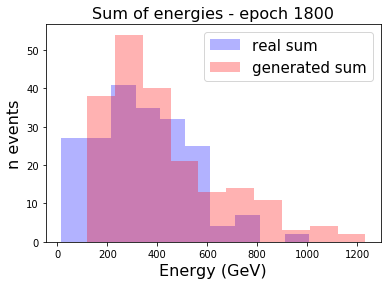

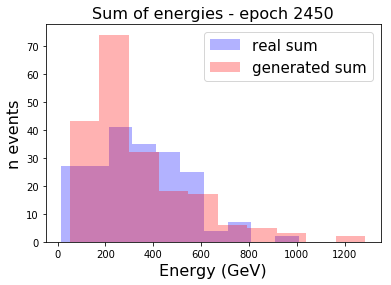

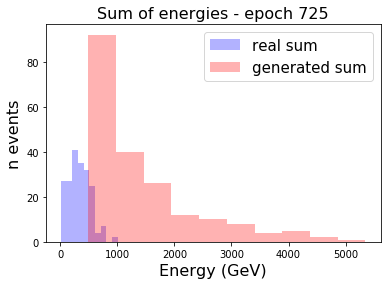

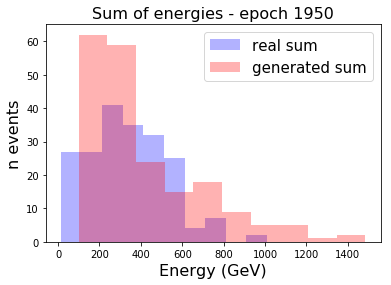

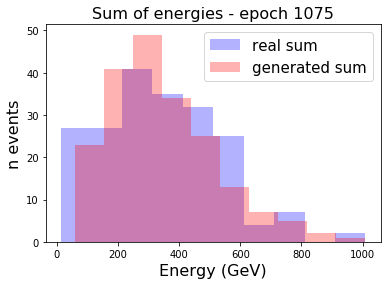

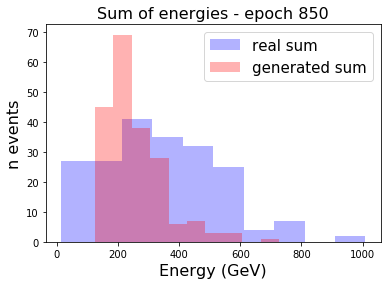

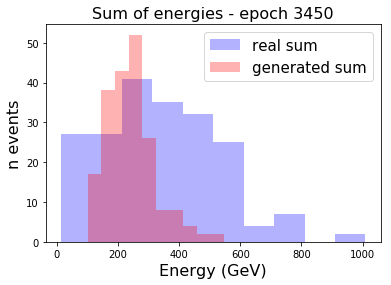

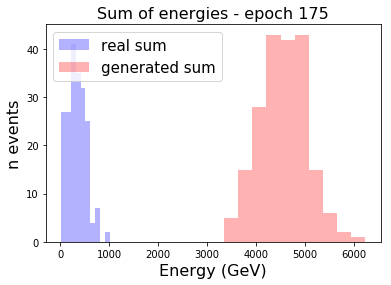

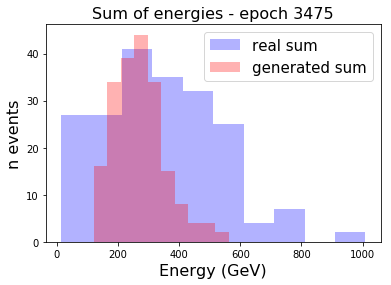

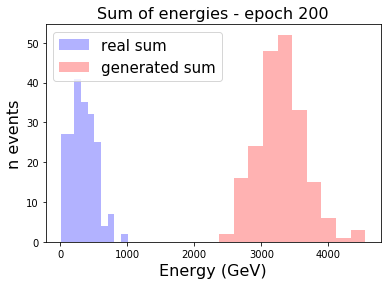

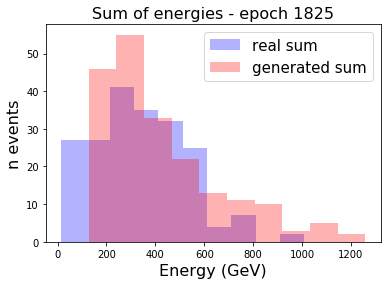

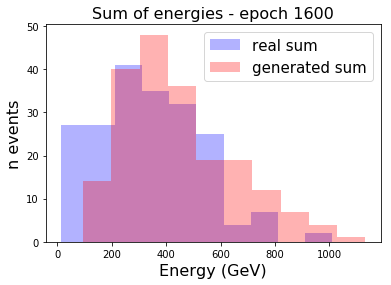

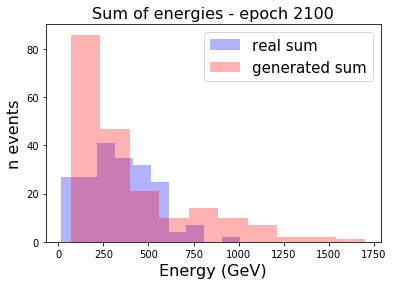

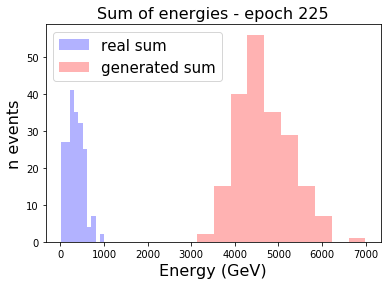

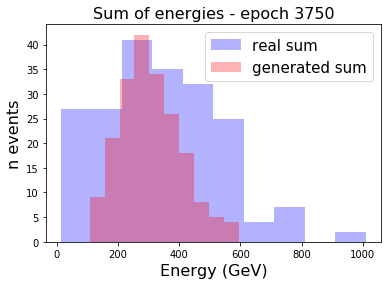

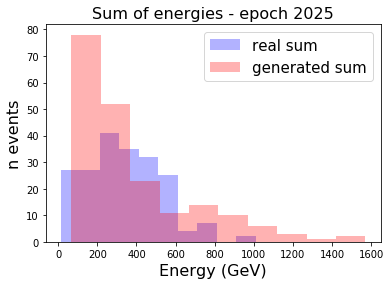

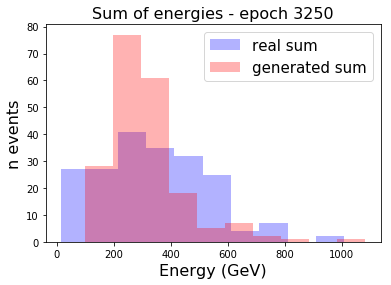

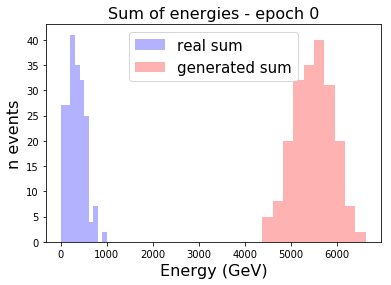

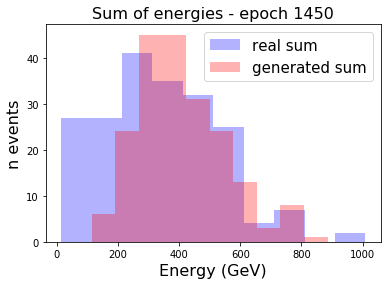

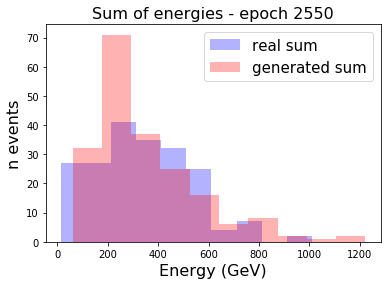

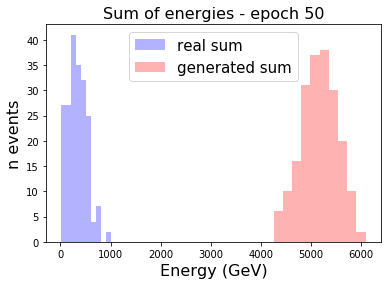

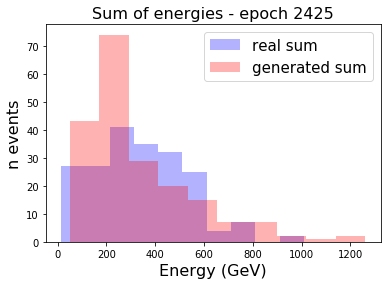

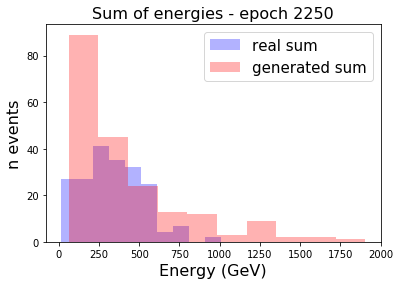

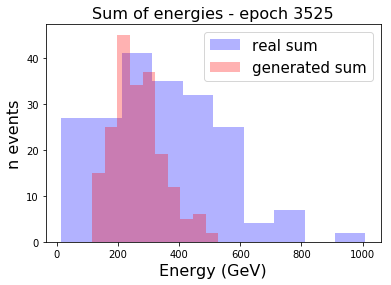

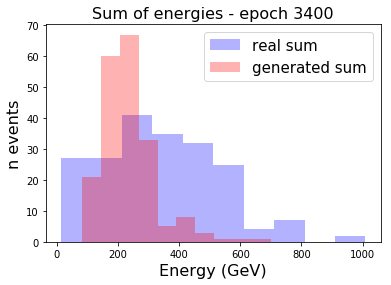

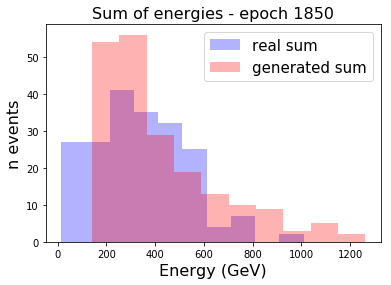

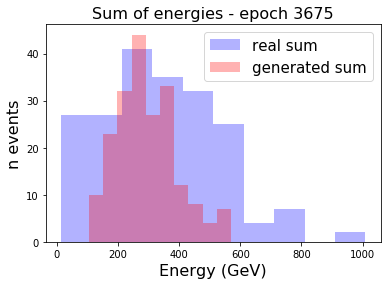

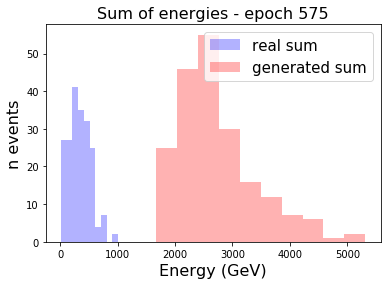

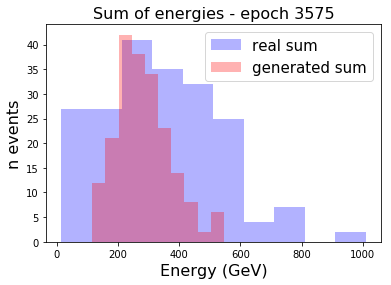

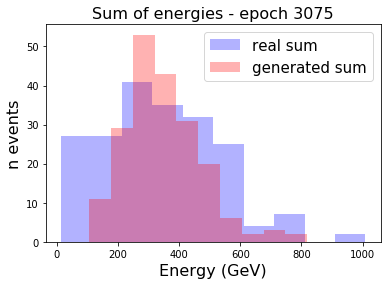

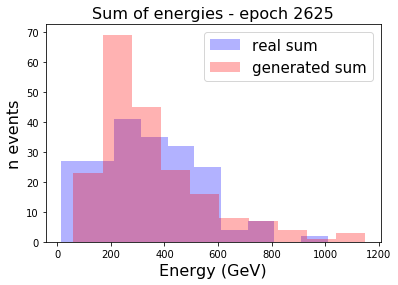

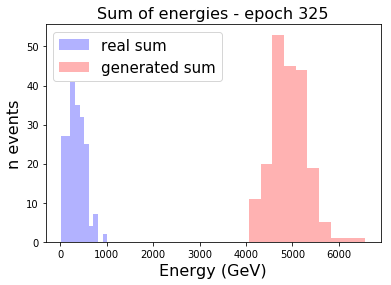

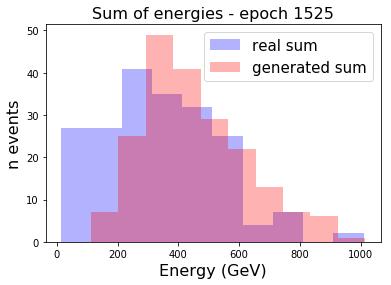

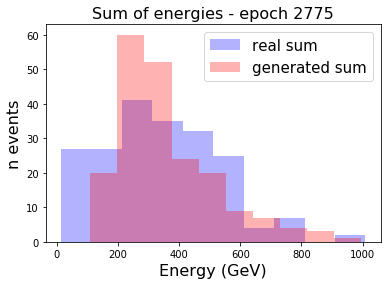

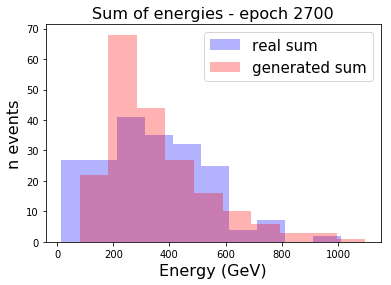

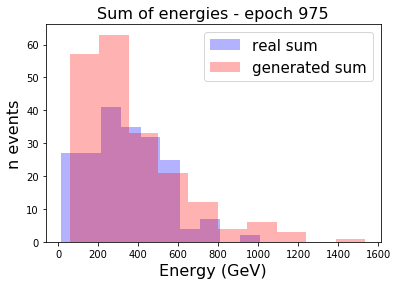

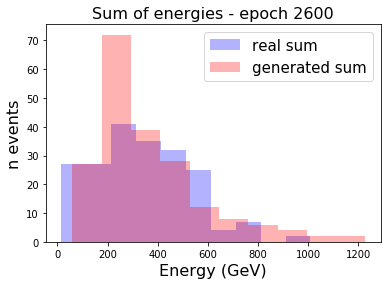

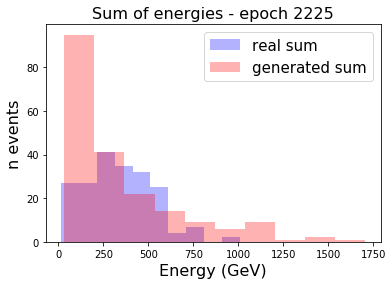

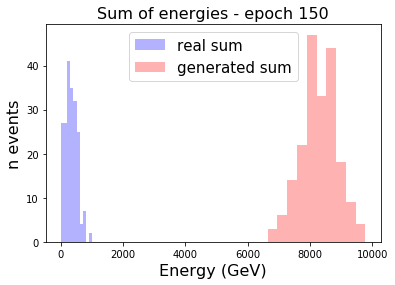

In [8]:
plotHist(inp_sum, all_g_weight1, gen_model1)

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


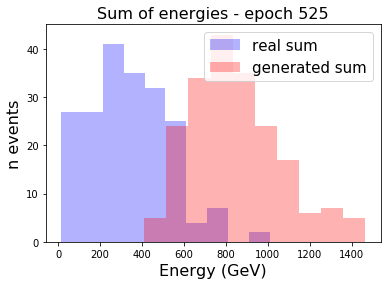

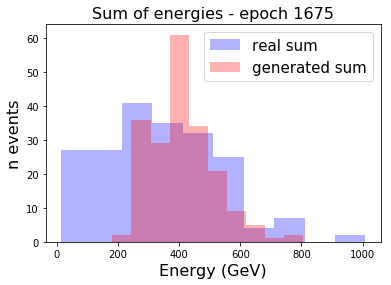

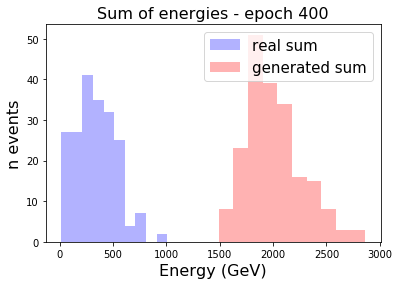

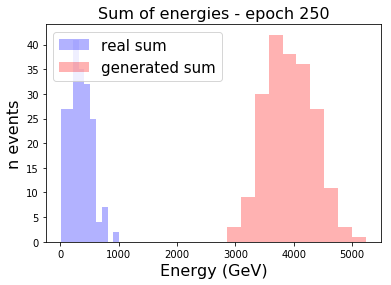

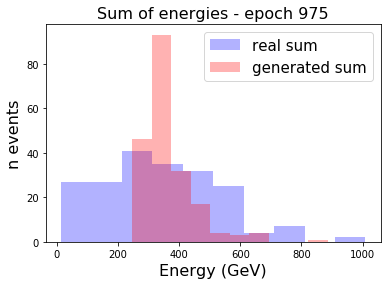

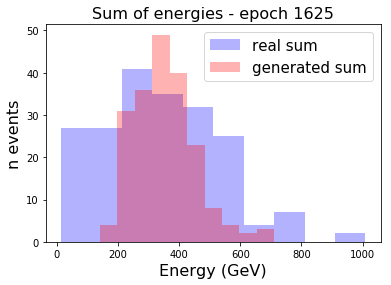

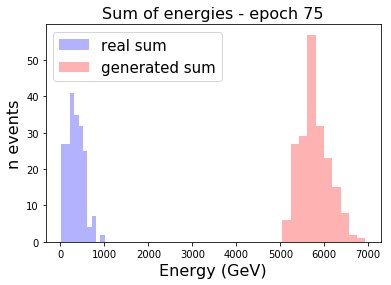

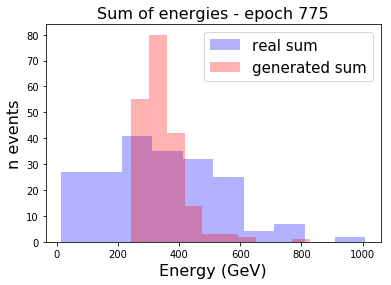

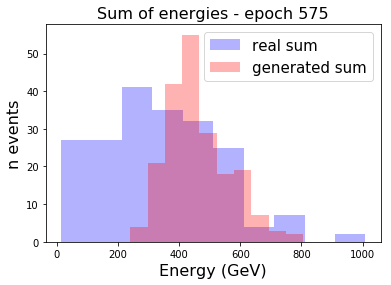

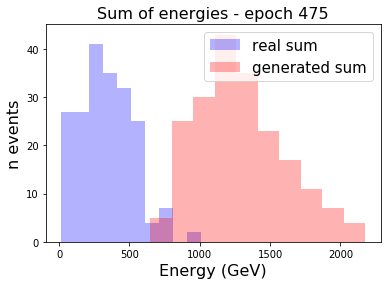

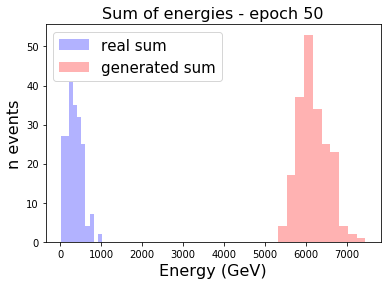

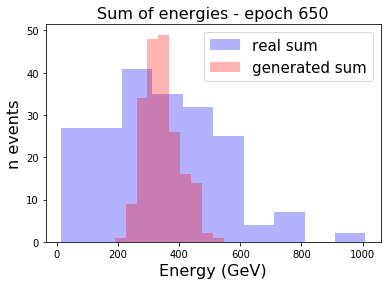

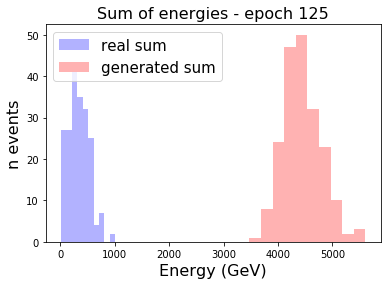

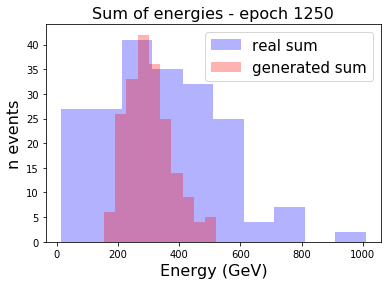

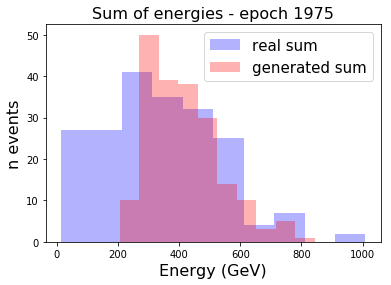

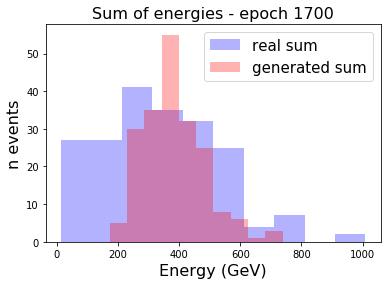

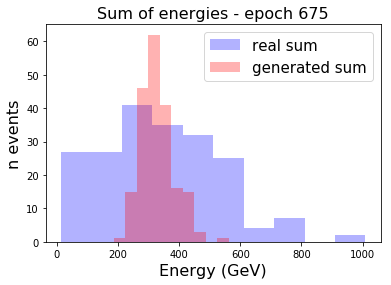

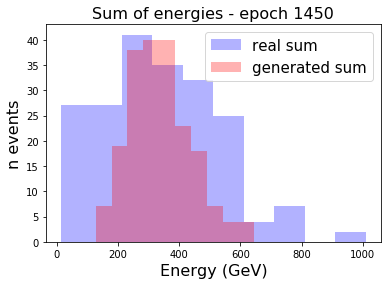

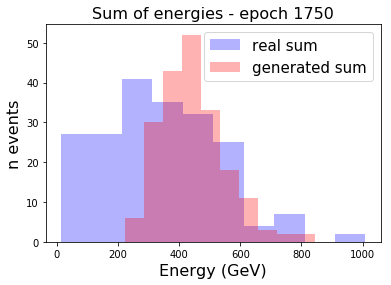

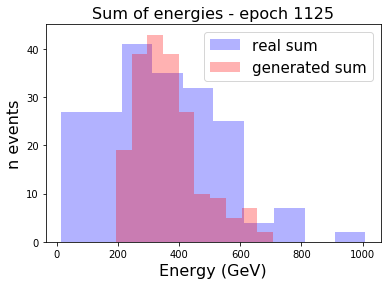

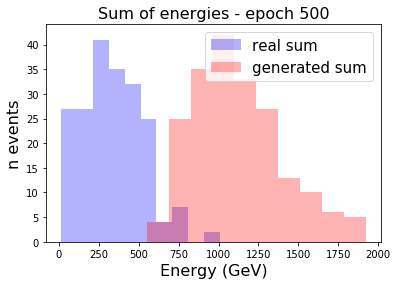

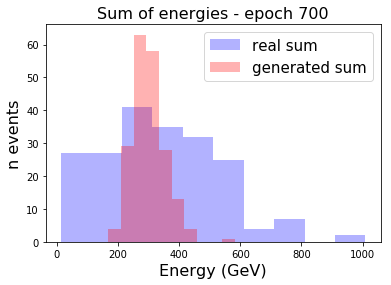

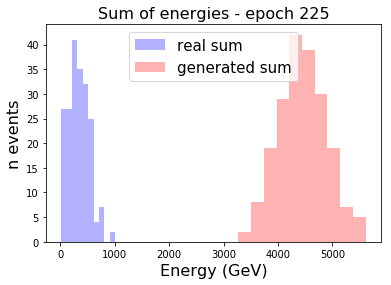

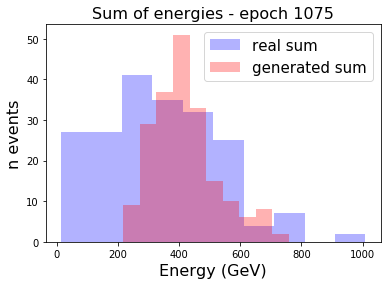

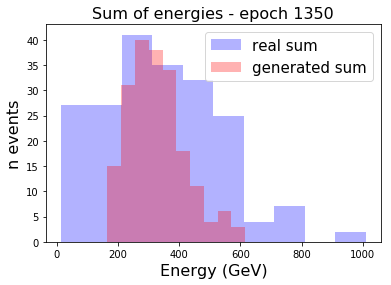

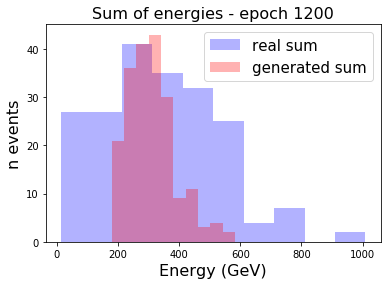

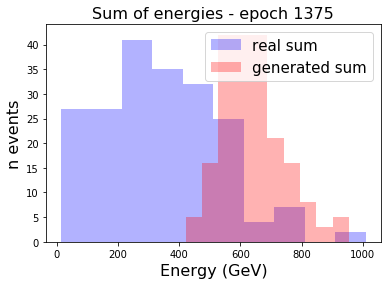

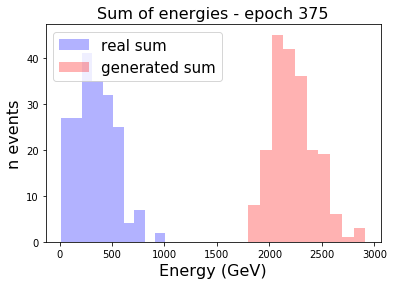

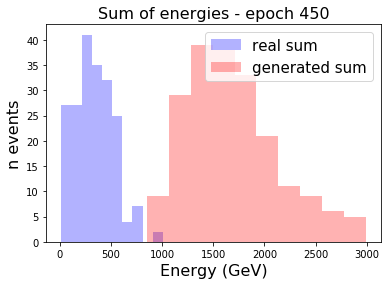

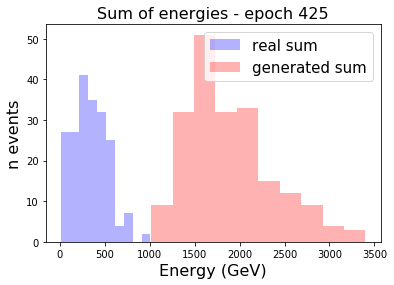

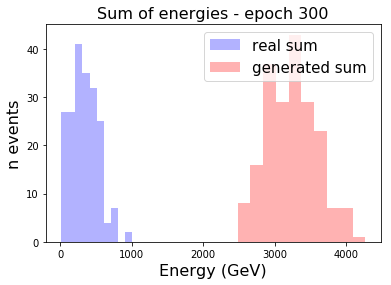

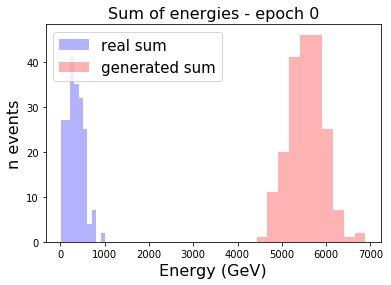

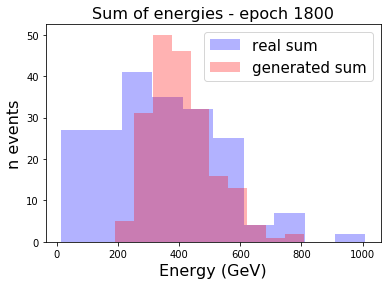

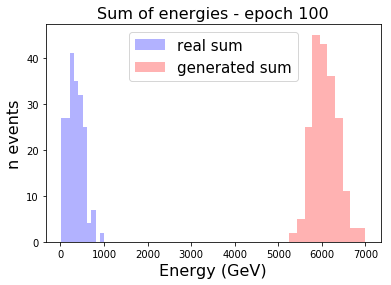

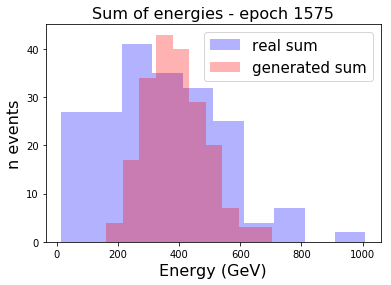

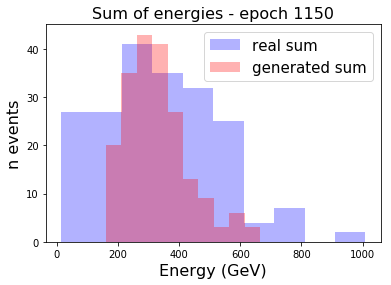

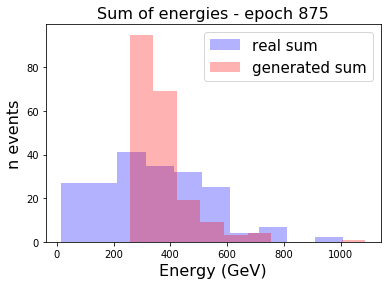

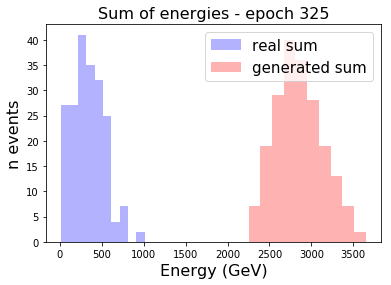

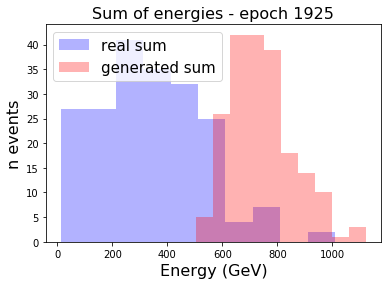

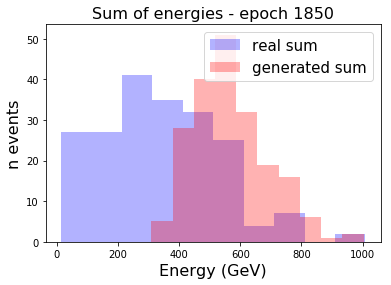

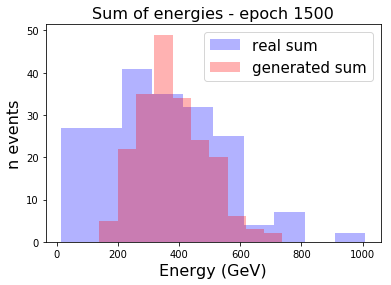

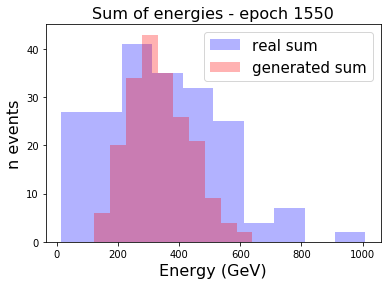

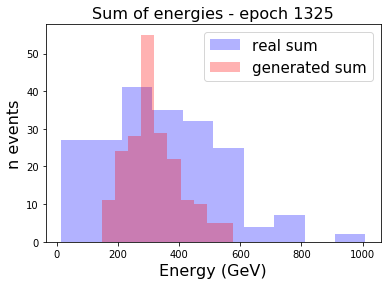

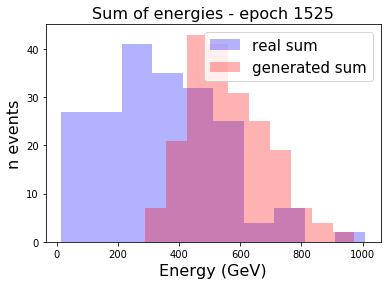

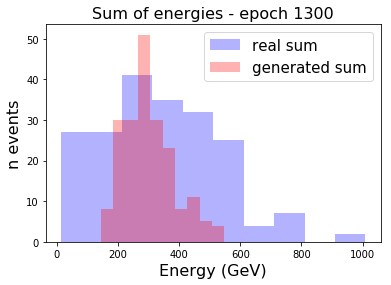

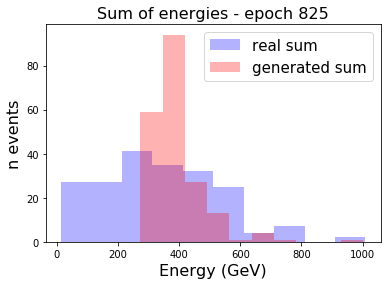

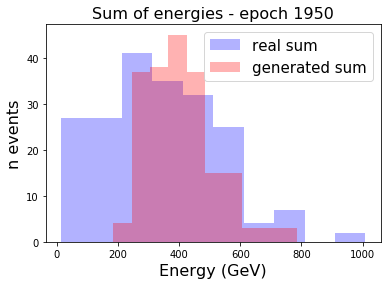

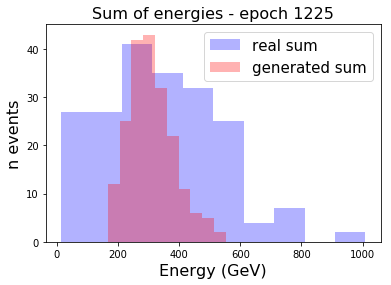

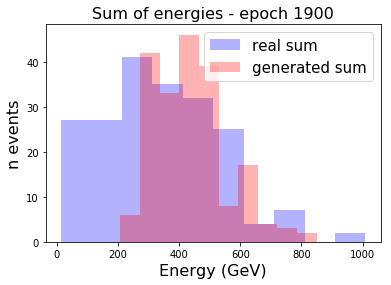

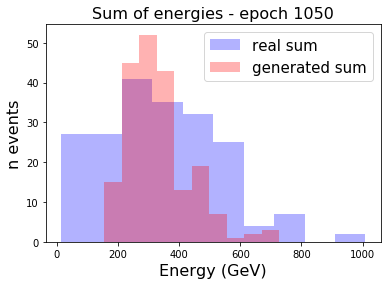

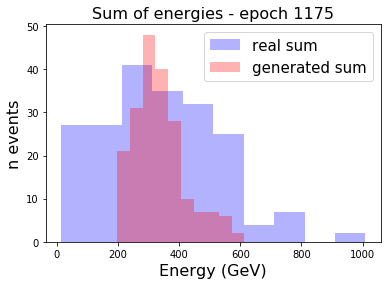

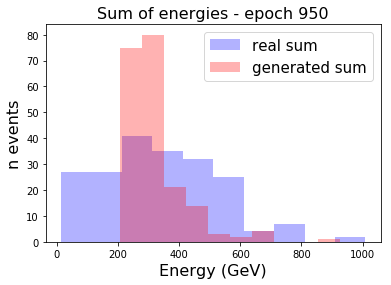

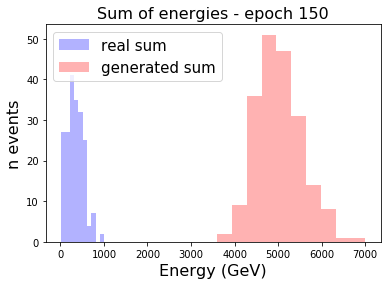

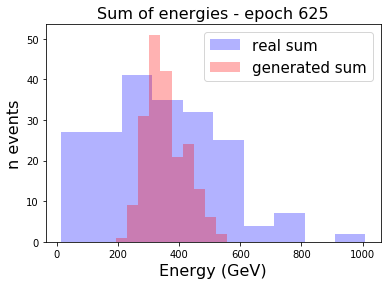

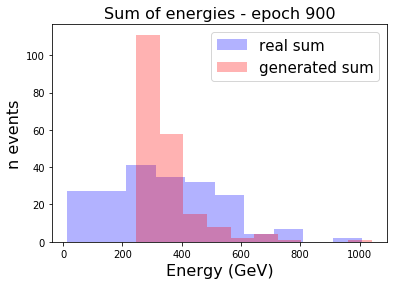

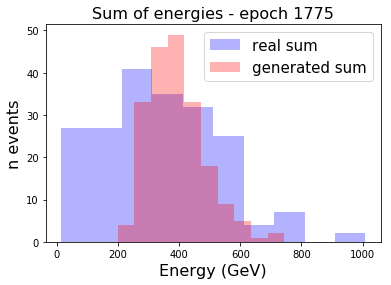

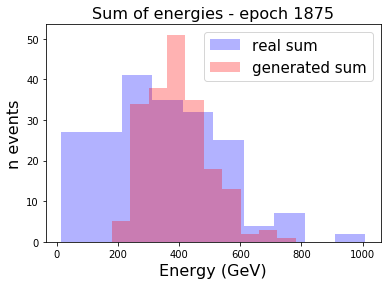

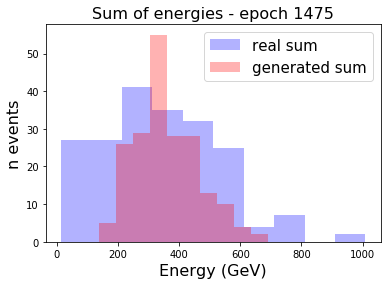

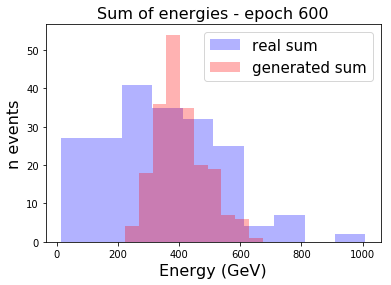

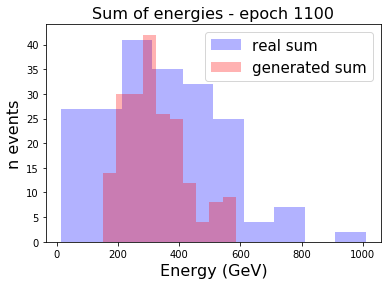

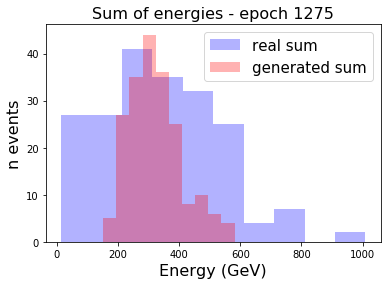

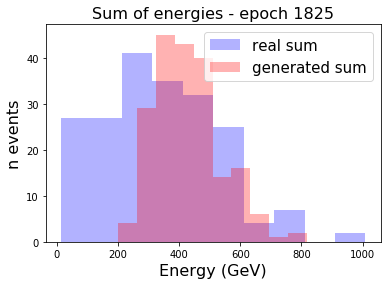

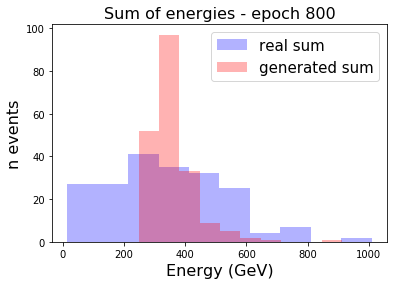

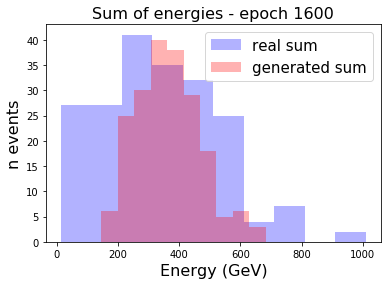

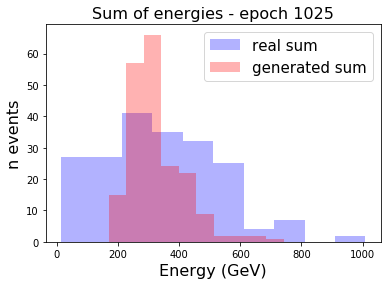

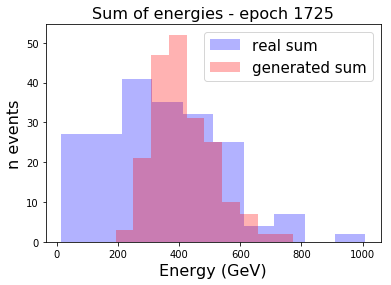

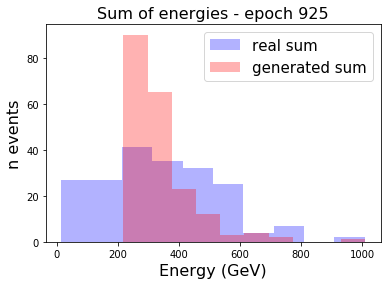

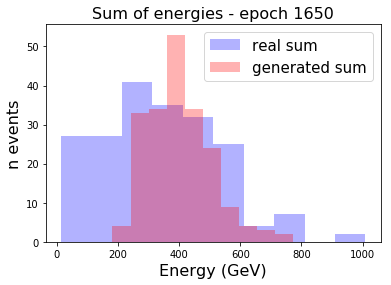

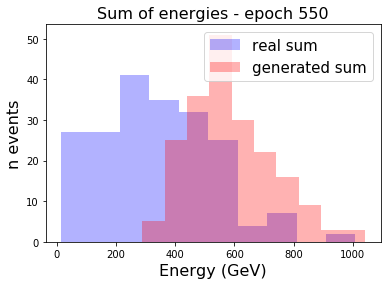

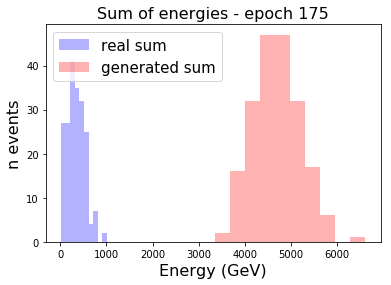

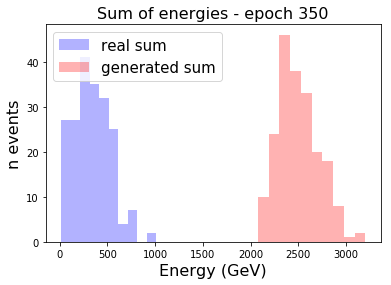

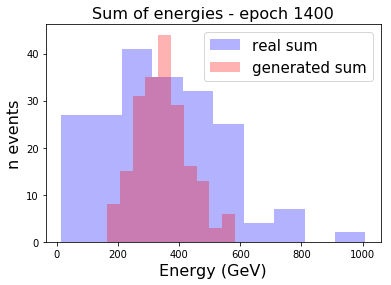

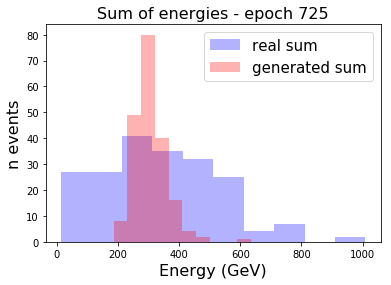

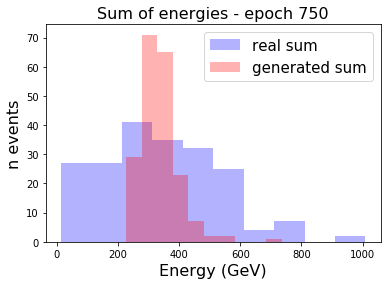

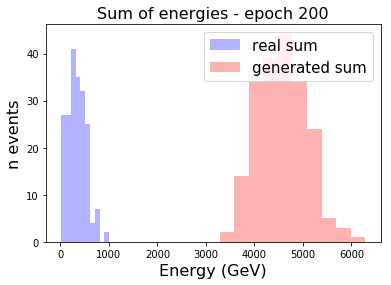

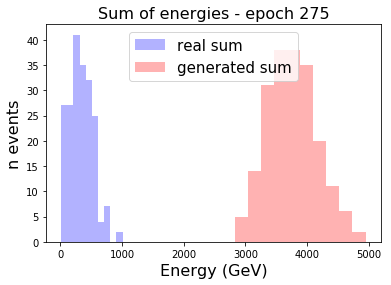

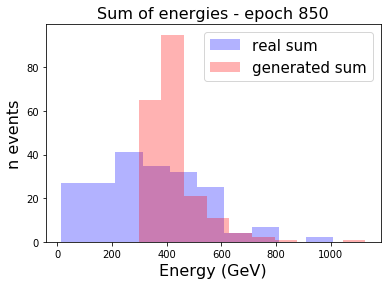

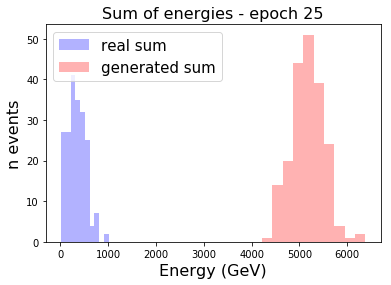

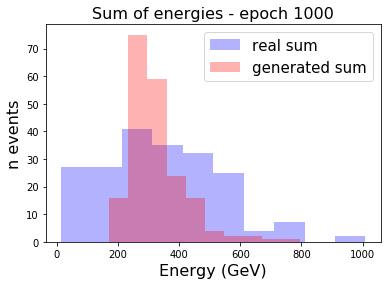

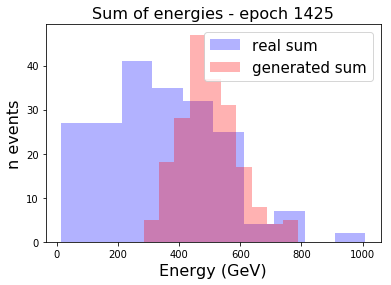

In [9]:
plotHist(inp_sum, all_g_weight2, gen_model2)